<a href="https://colab.research.google.com/github/Parisasuchdev/outlier_detection/blob/main/outlier_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/outlier_detection

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/outlier_detection


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import math

In [47]:
df = pd.read_csv('CTG_Dataset.csv')
df.drop(['FileName', 'Date', 'SegFile'], axis=1, inplace=True) # replacing unnecessary records because they don't directly impact the results

In [48]:
columns = ['b', 'e', 'LBE', 'LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV',
       'DL', 'DS', 'DP', 'DR', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode',
       'Mean', 'Median', 'Variance', 'Tendency', 'A', 'B', 'C', 'D', 'E', 'AD',
       'DE', 'LD', 'FS', 'SUSP', 'CLASS']

In [49]:
summary_stats = df.describe()
print(summary_stats)

                 b            e          LBE           LB           AC  \
count  2126.000000  2126.000000  2126.000000  2126.000000  2126.000000   
mean    878.439793  1702.877234   133.303857   133.303857     2.722484   
std     894.084748   930.919143     9.840844     9.840844     3.560850   
min       0.000000   287.000000   106.000000   106.000000     0.000000   
25%      55.000000  1009.000000   126.000000   126.000000     0.000000   
50%     538.000000  1241.000000   133.000000   133.000000     1.000000   
75%    1521.000000  2434.750000   140.000000   140.000000     4.000000   
max    3296.000000  3599.000000   160.000000   160.000000    26.000000   

                FM           UC         ASTV         MSTV         ALTV  ...  \
count  2127.000000  2127.000000  2127.000000  2127.000000  2127.000000  ...   
mean      7.503056     3.669017    47.008933     1.335449     9.884814  ...   
std      39.030452     2.877148    17.210648     0.891543    18.476534  ...   
min       0.00000

In [50]:
# splitting data
X = df.drop(['NSP'], axis=1)
# since data is continuous, we can replace NaN values with mean
X = df.drop(['NSP'], axis=1).copy()  # explicitly creates a copy of the DataFrame
X.fillna(X.mean(), inplace=True)  # apply .fillna() to the copy
# to impute most frequest values in categorical class
imputer = SimpleImputer(strategy='most_frequent')
df['NSP'] = imputer.fit_transform(df[['NSP']])
df['NSP'].isna().sum() # imputed none values
y = df['NSP']

scaler = StandardScaler()
X = scaler.fit_transform(X)
X.shape

(2129, 36)

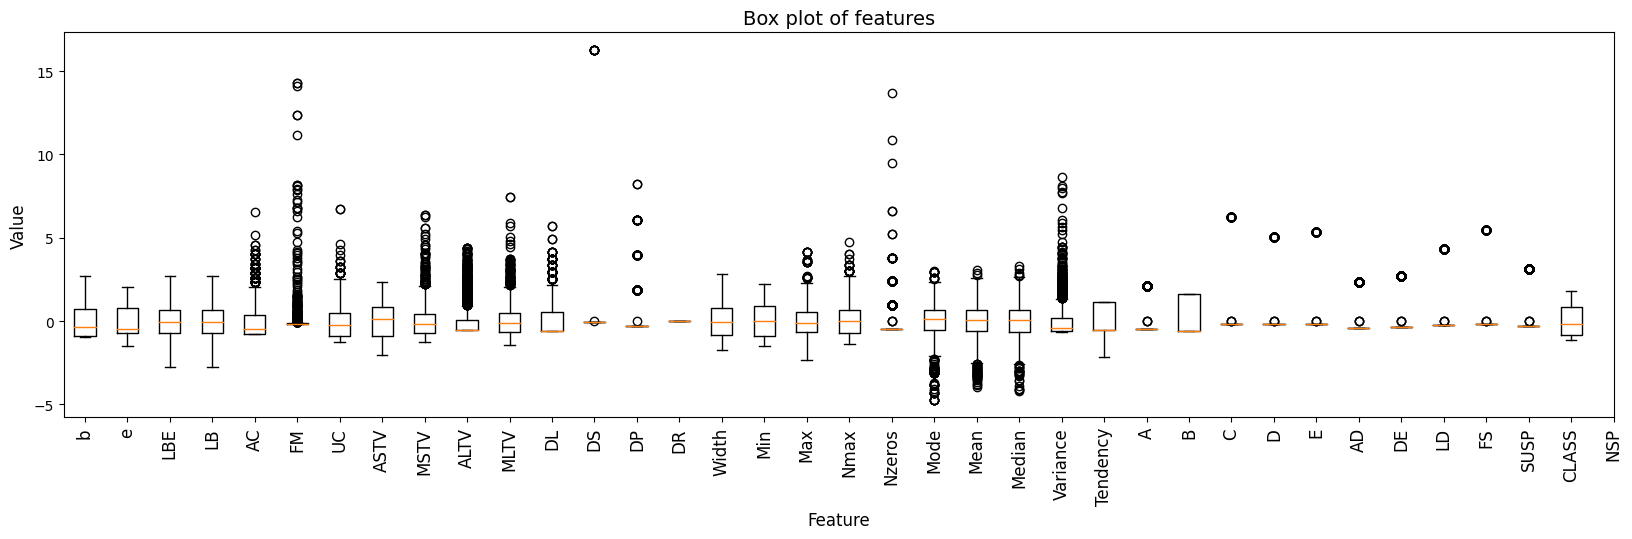

In [51]:
columns = df.columns
plt.figure(figsize=(20, 5))
plt.boxplot(X)
plt.xticks(range(1, len(columns)+1), columns, rotation=90, fontsize=12)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Box plot of features', fontsize=14)
plt.show()


# Models

we will test methods using PCA and without using PCA and evaluating by calculating f1 score

but we are also calculting the outlier detection using PCA

## Dimensionality Reduction
### PCA


[0.20441235 0.11996356]


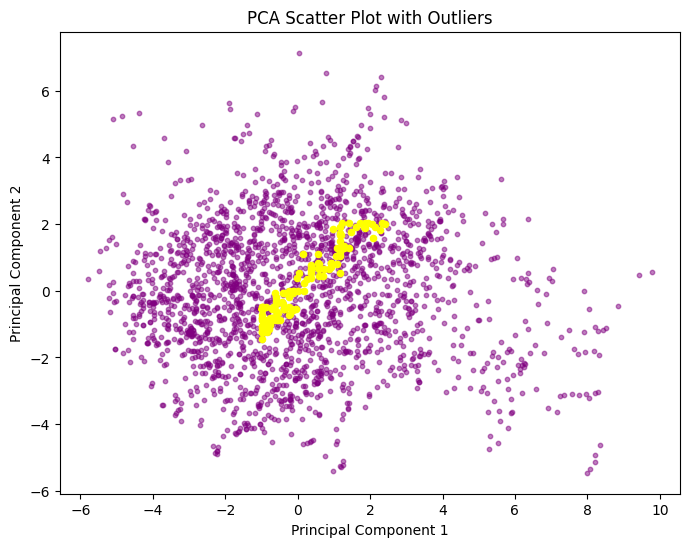

In [52]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# identifying outliers
outliers = X[np.where(np.logical_or(X_pca[:, 0] > 5, X_pca[:, 1] > 5))] # setting up a threshold
print(pca.explained_variance_ratio_) # shows the ratio covered by two components


# plotting the data and outliers
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, color='purple', alpha=0.5)
plt.scatter(outliers[:, 0], outliers[:, 1], s=20, color='yellow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with Outliers')
plt.show()

## Classification Methods:

Isolation Forest and One-Class SVM are also anomaly detection methods that are derived from classification methods.

Isolation Forest is a tree-based ensemble method that randomly selects features and splits to isolate anomalous observations. The idea behind Isolation Forest is that anomalous observations are more easily separable from the rest of the data points and can be identified by a smaller number of splits.

One-Class SVM, on the other hand, is a Support Vector Machine-based method that learns a decision boundary that encompasses the entire normal data space. Any data point that falls outside of this boundary is considered an anomaly.



### OneClass SVM
- first - without PCA
- second - with PCA

number of outliers detected: 113
f1 score: 0.6787206150489916


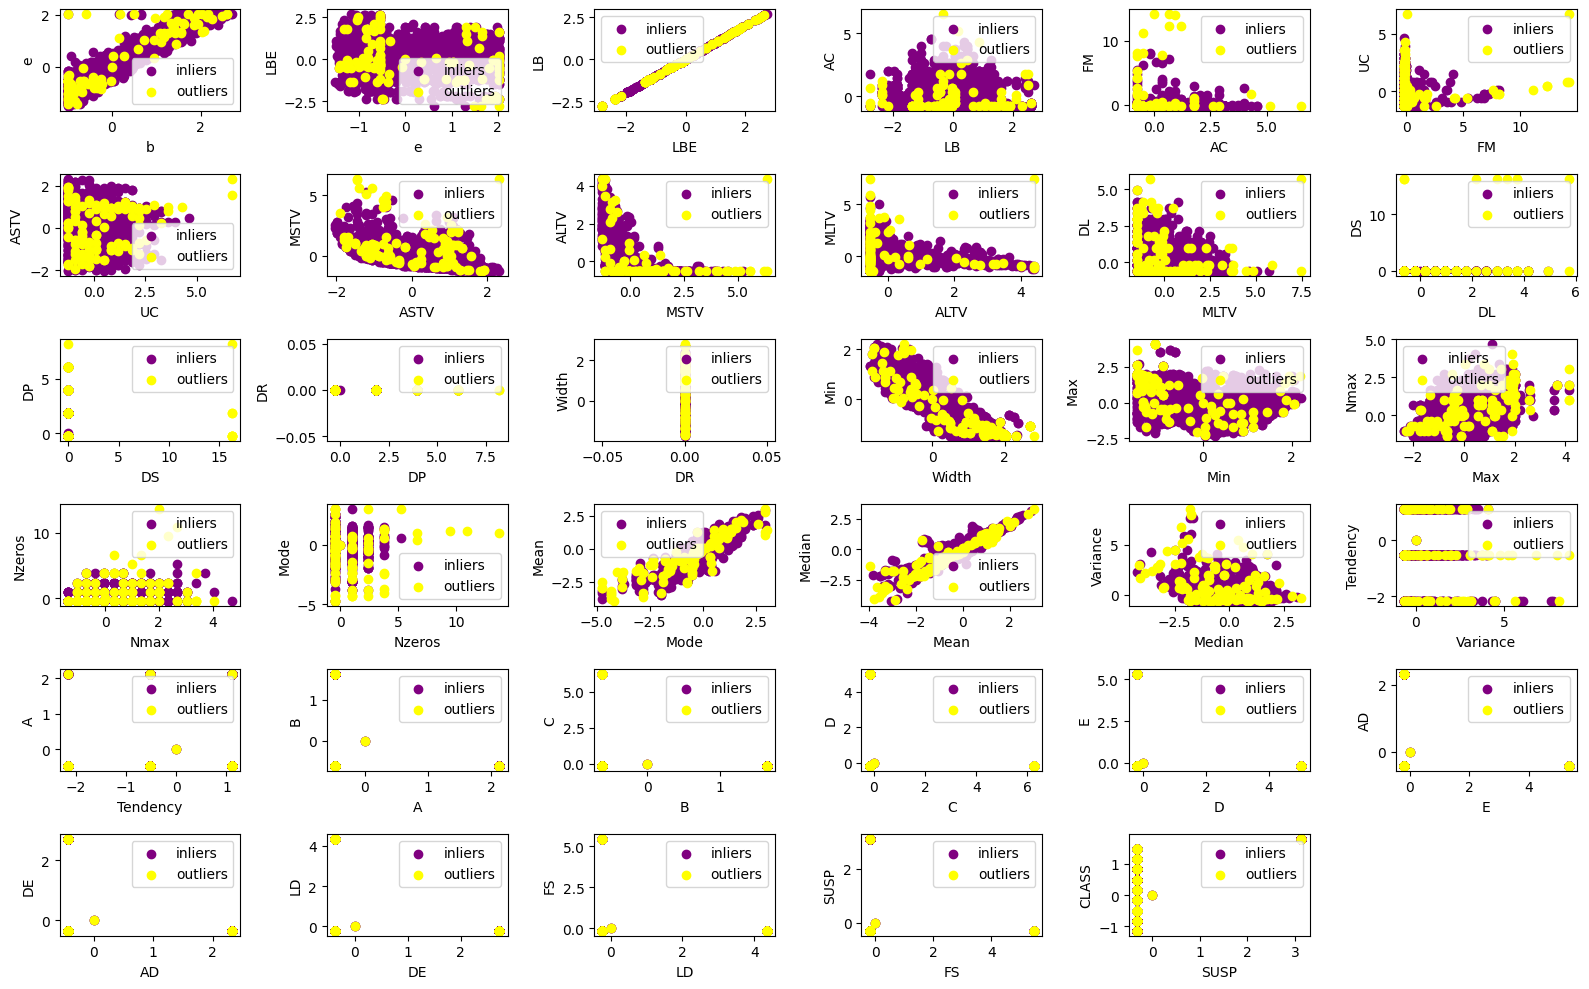

In [53]:
# create OneClassSVM estimator
clf = OneClassSVM(kernel='rbf', nu=0.05)
clf.fit(X)
# predict labels for all data
y_pred = clf.predict(X)
num_outliers = np.count_nonzero(y_pred == -1)
print(f'number of outliers detected: {num_outliers}')
# F1 score
f1 = f1_score(y, y_pred, average='weighted')
print(f'f1 score: {f1}')
# identify outliers
outliers = X[y_pred == -1] # only get rows where y_pred == -1

# remove outliers
X_no_outliers = X[y_pred == 1]


# determine the size of the grid
n_cols = 6  # set the number of columns
n_rows = math.ceil(X.shape[1] / n_cols)  # calculate the number of rows

# create the grid of subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 10))

# plot each pair of features
for i, ax in enumerate(axes.flat):
    if i < X.shape[1] - 1:
        x_col = X_no_outliers[:, i]
        y_col = X_no_outliers[:, i+1]
        ax.scatter(x_col, y_col, c='purple', label='inliers')
        ax.scatter(outliers[:, i], outliers[:, i+1], c='yellow', label='outliers')
        ax.set_xlabel(columns[i])
        ax.set_ylabel(columns[i+1])
        ax.legend()
    else:
        ax.axis('off')  # hide unused subplot

plt.tight_layout()  # adjust the layout
plt.show()


number of outliers detected: 110
f1 score: 0.6781668587680161


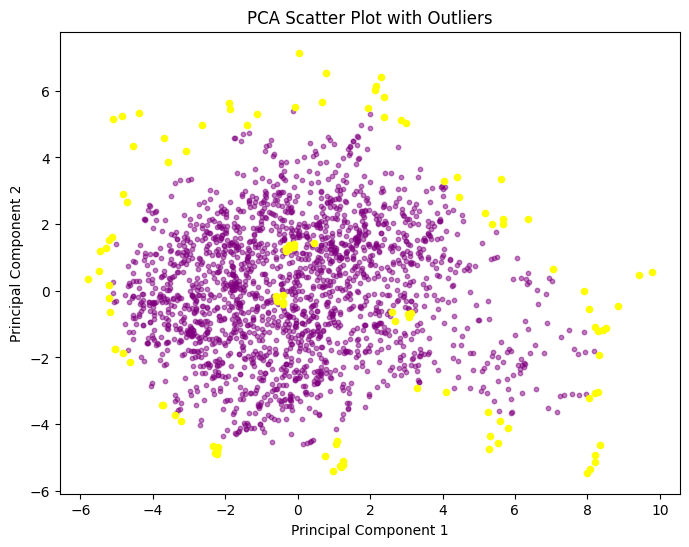

In [54]:
# create OneClassSVM estimator
clf = OneClassSVM(kernel='rbf', nu=0.05)
clf.fit(X_pca)
# predict labels for all data
y_pred = clf.predict(X_pca)
num_outliers = np.count_nonzero(y_pred == -1)
print(f'number of outliers detected: {num_outliers}')
# F1 score
f1 = f1_score(y, y_pred, average='weighted')
print(f'f1 score: {f1}')
# identify outliers
outliers = X_pca[y_pred == -1] # only get rows where y_pred == -1

# remove outliers
X_no_outliers = X_pca[y_pred == 1]

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, color='purple', alpha=0.5)
plt.scatter(outliers[:, 0], outliers[:, 1], s=20, color='yellow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with Outliers')
plt.show()

### Isolation Forest

number of outliers detected: 160
f1 score: 0.693957160449077


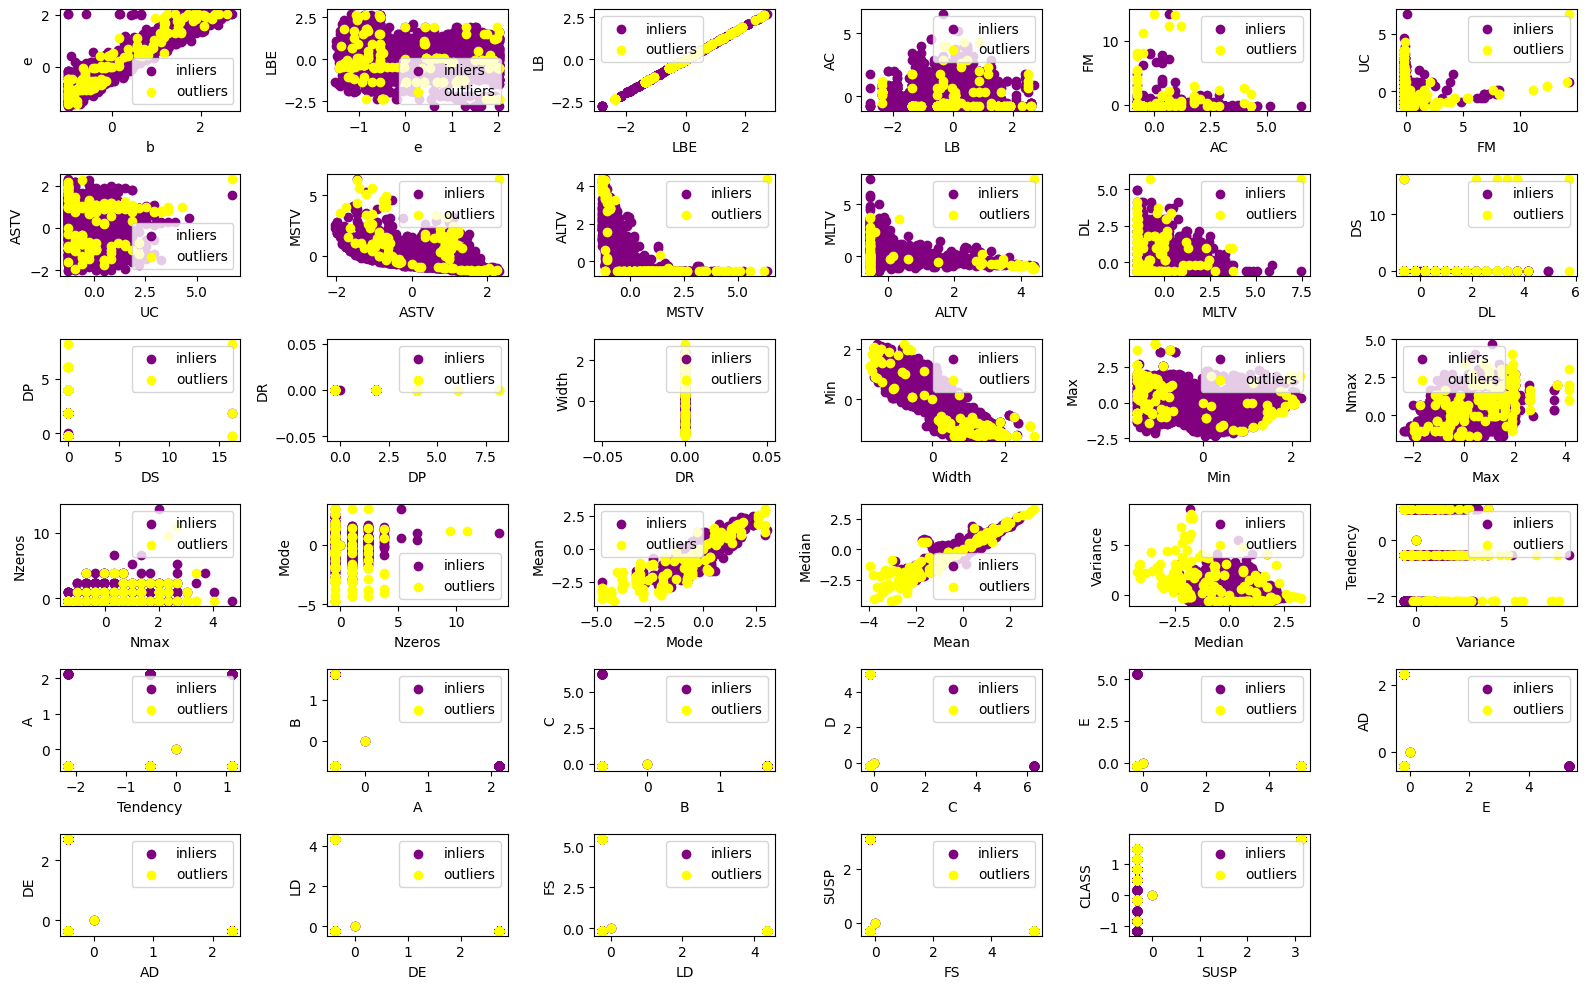

In [55]:
# perform isolation forest outlier detection
clf = IsolationForest()
clf.fit(X)
# predict labels for all data
y_pred = clf.predict(X)
num_outliers = np.count_nonzero(y_pred == -1)
print(f'number of outliers detected: {num_outliers}')
# F1 score
f1 = f1_score(y, y_pred, average='weighted')
print(f'f1 score: {f1}')
# identify outliers
outliers = X[y_pred == -1] # only get rows where y_pred == -1

# remove outliers
X_no_outliers = X[y_pred == 1]

# determine the size of the grid
n_cols = 6  # set the number of columns
n_rows = math.ceil(X.shape[1] / n_cols)  # calculate the number of rows

# create the grid of subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 10))

# plot each pair of features
for i, ax in enumerate(axes.flat):
    if i < X.shape[1] - 1:
        x_col = X_no_outliers[:, i]
        y_col = X_no_outliers[:, i+1]
        ax.scatter(x_col, y_col, c='purple', label='inliers')
        ax.scatter(outliers[:, i], outliers[:, i+1], c='yellow', label='outliers')
        ax.set_xlabel(columns[i])
        ax.set_ylabel(columns[i+1])
        ax.legend()
    else:
        ax.axis('off')  # hide unused subplot

plt.tight_layout()  # adjust the layout
plt.show()

number of outliers detected: 436
f1 score: 0.6651262166786581


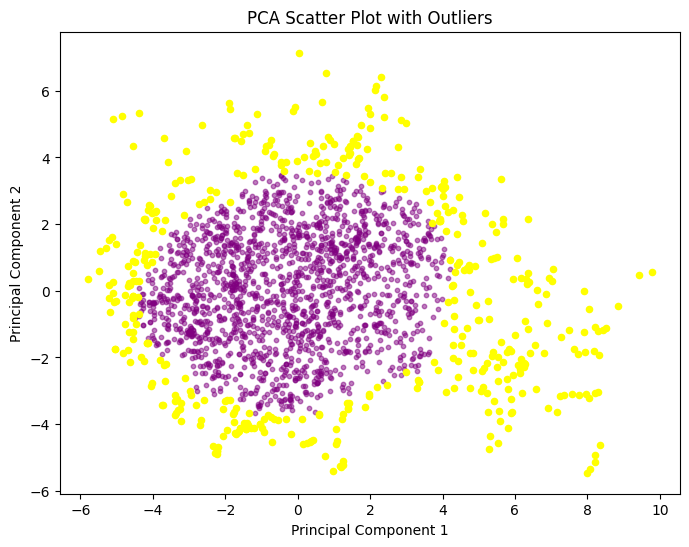

In [56]:
# perform isolation forest outlier detection
clf = IsolationForest()
clf.fit(X_pca)
# predict labels for all data
y_pred = clf.predict(X_pca)
num_outliers = np.count_nonzero(y_pred == -1)
print(f'number of outliers detected: {num_outliers}')
# F1 score
f1 = f1_score(y, y_pred, average='weighted')
print(f'f1 score: {f1}')
# identify outliers
outliers = X_pca[y_pred == -1] # only get rows where y_pred == -1

# plot outliers
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, color='purple', alpha=0.5)
plt.scatter(outliers[:, 0], outliers[:, 1], s=20, color='yellow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with Outliers')
plt.show()

## Density based methods
### LOF

LOF (Local Outlier Factor) is also an anomaly detection method, but it's a density-based approach. It determines the local density of a data point relative to its neighbors, and assigns an outlier score based on how much smaller the density of the point is compared to its neighbors. A point that has a much lower density than its neighbors is considered an outlier. LOF is based on the assumption that outliers are not only far from the center of the data, but also far from their surrounding neighbors. LOF has been shown to perform well on high-dimensional data and can handle noise and varying densities in the data.

number of outliers detected: 213
f1 score: 0.6615399617770744


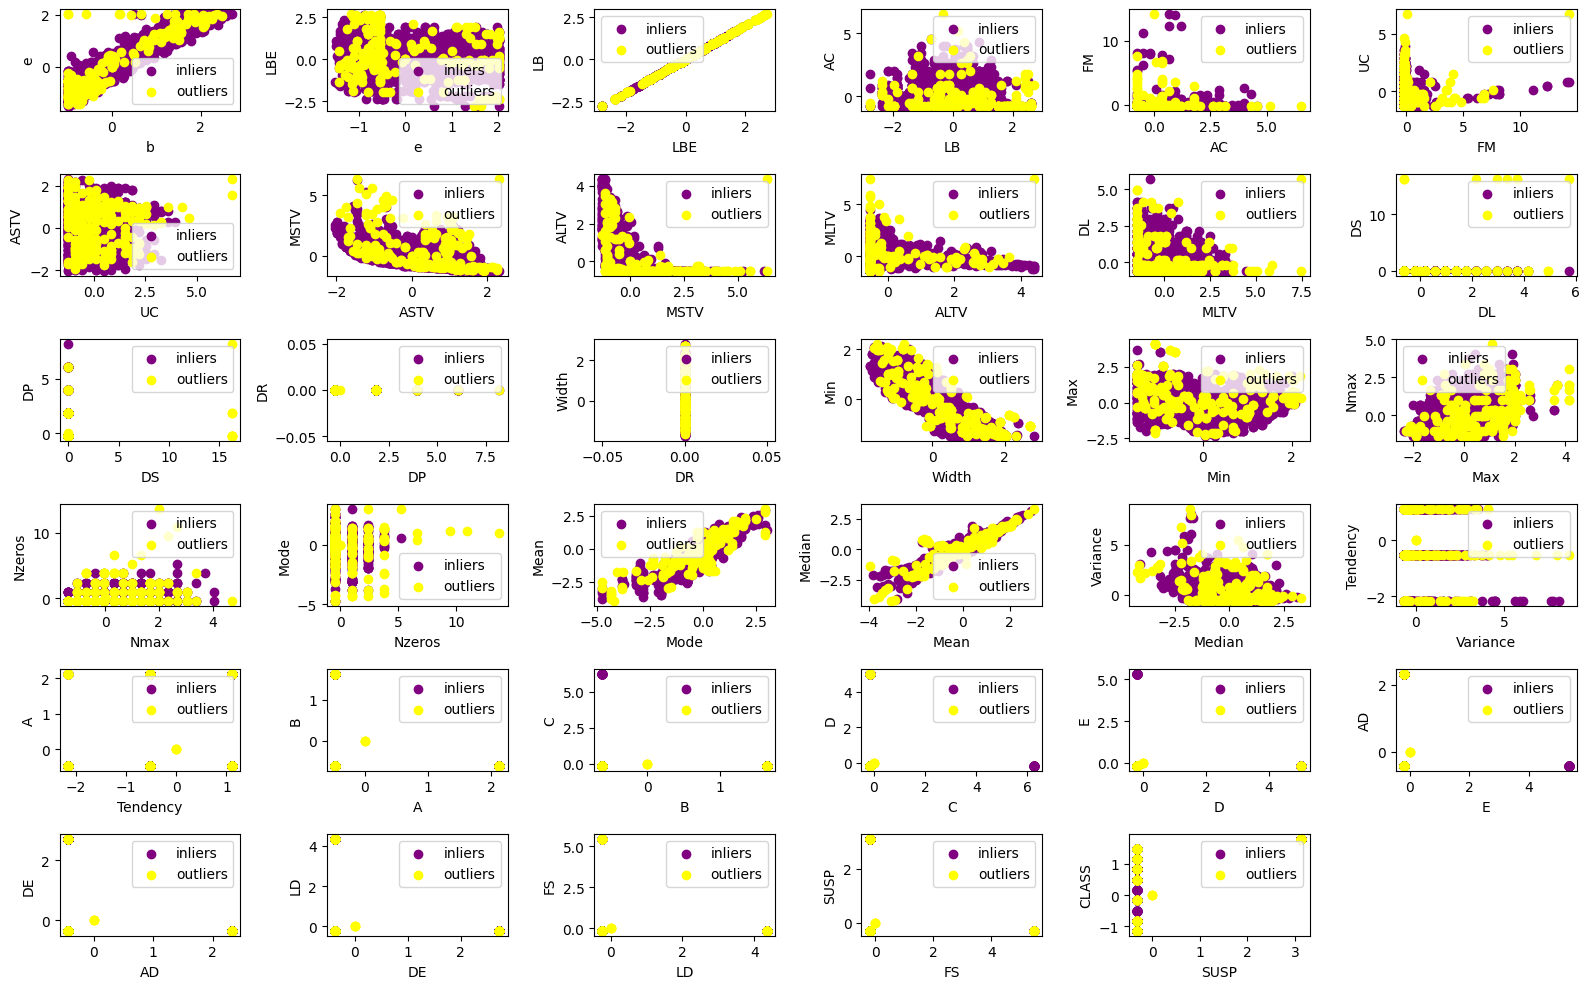

In [58]:
# perform LOF outlier detection
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# predict labels for all data
y_pred = clf.fit_predict(X)
num_outliers = np.count_nonzero(y_pred == -1)
print(f'number of outliers detected: {num_outliers}')
# F1 score
f1 = f1_score(y, y_pred, average='weighted')
print(f'f1 score: {f1}')
# identify outliers
outliers = X[y_pred == -1] # only get rows where y_pred == -1

# remove outliers
X_no_outliers = X[y_pred == 1]

# determine the size of the grid
n_cols = 6  # set the number of columns
n_rows = math.ceil(X.shape[1] / n_cols)  # calculate the number of rows

# create the grid of subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 10))

# plot each pair of features
for i, ax in enumerate(axes.flat):
    if i < X.shape[1] - 1:
        x_col = X_no_outliers[:, i]
        y_col = X_no_outliers[:, i+1]
        ax.scatter(x_col, y_col, c='purple', label='inliers')
        ax.scatter(outliers[:, i], outliers[:, i+1], c='yellow', label='outliers')
        ax.set_xlabel(columns[i])
        ax.set_ylabel(columns[i+1])
        ax.legend()
    else:
        ax.axis('off')  # hide unused subplot

plt.tight_layout()  # adjust the layout
plt.show()

number of outliers detected: 213
f1 score: 0.6680769179211166


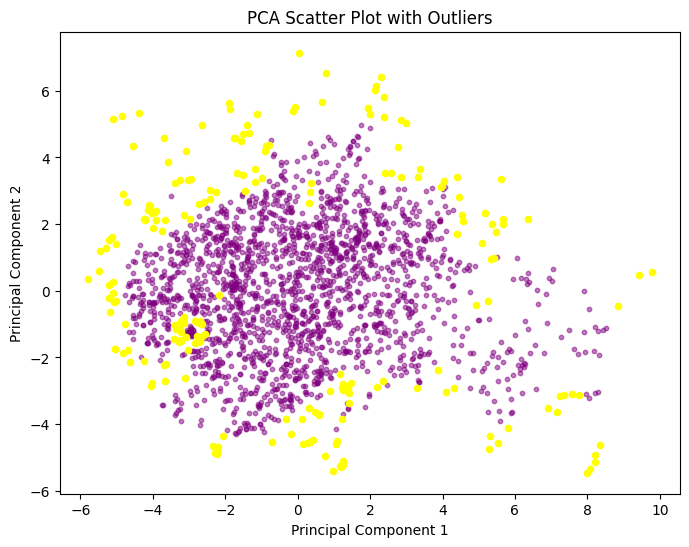

In [59]:
# perform LOF outlier detection
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(X_pca)
num_outliers = np.count_nonzero(y_pred == -1)
print(f'number of outliers detected: {num_outliers}')
# F1 score
f1 = f1_score(y, y_pred, average='weighted')
print(f'f1 score: {f1}')
# identify outliers
outliers = X_pca[y_pred == -1] # only get rows where y_pred == -1

# plot outliers
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, color='purple', alpha=0.5)
plt.scatter(outliers[:, 0], outliers[:, 1], s=20, color='yellow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with Outliers')
plt.show()

## Clustering Based Methods

### DBSCAN

number of outliers detected: 431
f1 score: 0.0
0.1636137962724816


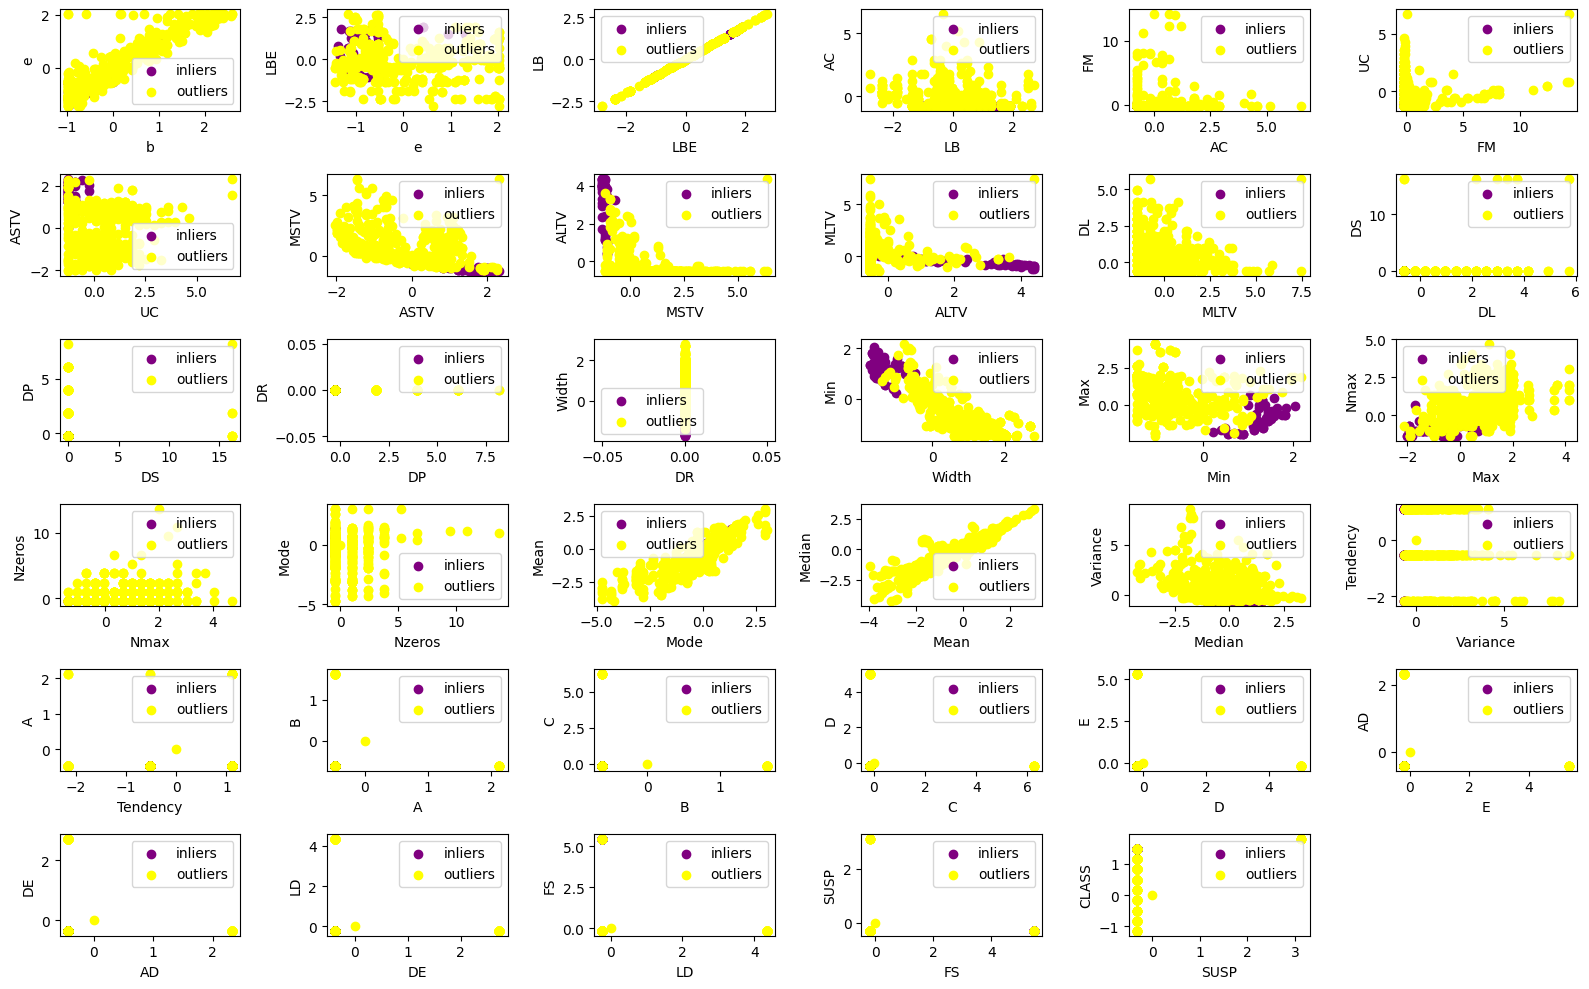

In [61]:
from sklearn import metrics

clf = DBSCAN(eps=3, min_samples=10)
y_pred = clf.fit_predict(X)
num_outliers = np.count_nonzero(y_pred == -1)
print(f'number of outliers detected: {num_outliers}')
# F1 score
f1 = f1_score(y, y_pred, average='weighted')
print(f'f1 score: {f1}')
# identify outliers
outliers = X[y_pred == -1] # only get rows where y_pred == -1

# remove outliers
X_no_outliers = X[y_pred == 1]

silhouette_score = metrics.silhouette_score(X, y_pred)
print(silhouette_score)

# plot outliers
# determine the size of the grid
n_cols = 6  # set the number of columns
n_rows = math.ceil(X.shape[1] / n_cols)  # calculate the number of rows

# create the grid of subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 10))

# plot each pair of features
for i, ax in enumerate(axes.flat):
    if i < X.shape[1] - 1:
        x_col = X_no_outliers[:, i]
        y_col = X_no_outliers[:, i+1]
        ax.scatter(x_col, y_col, c='purple', label='inliers')
        ax.scatter(outliers[:, i], outliers[:, i+1], c='yellow', label='outliers')
        ax.set_xlabel(columns[i])
        ax.set_ylabel(columns[i+1])
        ax.legend()
    else:
        ax.axis('off')  # hide unused subplot

plt.tight_layout()  # adjust the layout
plt.show()

number of outliers detected: 0
f1 score: 0.0


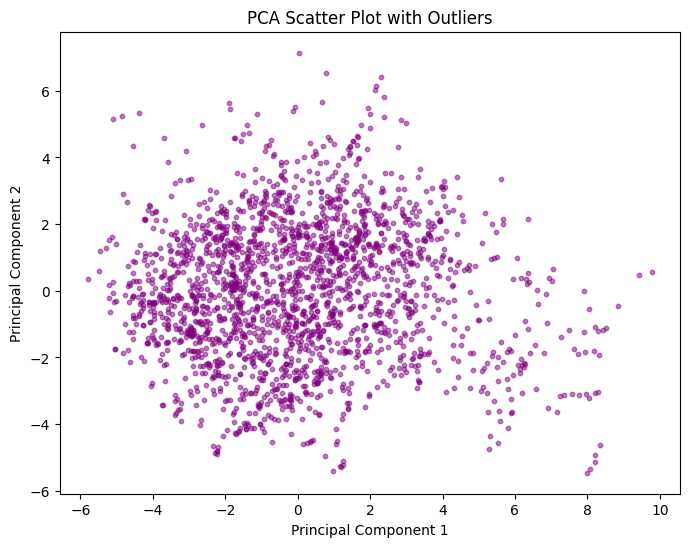

In [62]:
from sklearn import metrics

clf = DBSCAN(eps=3, min_samples=10)
y_pred = clf.fit_predict(X_pca)
num_outliers = np.count_nonzero(y_pred == -1)
print(f'number of outliers detected: {num_outliers}')
# F1 score
f1 = f1_score(y, y_pred, average='weighted')
print(f'f1 score: {f1}')
# identify outliers
outliers = X_pca[y_pred == -1] # only get rows where y_pred == -1

# plot outliers
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, color='purple', alpha=0.5)
plt.scatter(outliers[:, 0], outliers[:, 1], s=20, color='yellow')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with Outliers')
plt.show()
